In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import re


### Preprocessing

In [58]:

# 파일 경로 설정
path = "/Users/roycecho/Desktop/3-1/AI/data/"

# 엑셀 파일을 읽어서 데이터프레임으로 변환
final_xl = pd.read_excel(path + '지스트광학_정리.xlsx')

final_xl.head()


,Year,Funding,Cluster_keyword
0,2017,0,0
1,2017,52500000,0
2,2018,85789000,0
3,2021,537998366,2
4,2015,104226942,3


In [133]:
# CSV 파일로 저장
csv_path = "/Users/roycecho/Desktop/3-1/AI/data/지스트정리.csv"
final_xl.to_csv(csv_path, index=None, header=True)

# CSV 파일을 읽어서 데이터프레임으로 변환
df = pd.read_csv(csv_path)

# 데이터프레임 출력
df.head()



,Year,Funding,Cluster_keyword
0,2017,0,0
1,2017,52500000,0
2,2018,85789000,0
3,2021,537998366,2
4,2015,104226942,3


In [134]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


path_CG = "/Users/roycecho/Desktop/3-1/AI/try/지스트정리.csv"
df.to_csv(path_CG, index=False, header=True)

df.head()

,Year,Funding,Cluster_keyword
0,2017,0,0
1,2017,52500000,0
2,2018,85789000,0
3,2021,537998366,2
4,2015,104226942,3


### Clustering from GPT

In [135]:

clusters = {
    0: ['0'],
    1: ['1'],
    2: ['2'],
    3: ['3']
}


### New Model - Poly

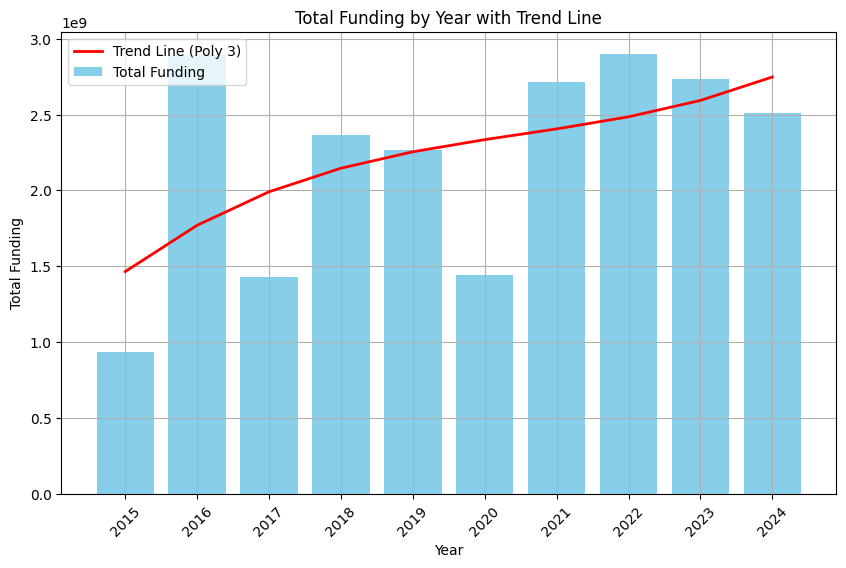

Best Degree: 3, Best RMSE: 552266538.39


In [136]:
# 연도별 전체 예산 합계 계산
total_funding_by_year = df.groupby('Year')['Funding'].sum().reset_index()
total_funding_by_year.columns = ['Year', 'Total_Funding']



# 다항 회귀 모델 학습
X = total_funding_by_year['Year'].values.reshape(-1, 1)
y = total_funding_by_year['Total_Funding'].values

best_degree = 1
best_rmse = float('inf')
best_model = None
best_poly = None
best_y_pred = None

# 다양한 차수의 다항 회귀 모델 학습 및 평가
for degree in range(1, 40):  # 1차부터 5차까지 시도
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    if rmse < best_rmse:
        best_rmse = rmse
        best_degree = degree
        best_model = model
        best_poly = poly
        best_y_pred = y_pred

# 연도별 전체 예산 합계 시각화 및 최적 추세선 추가
plt.figure(figsize=(10, 6))
plt.bar(total_funding_by_year['Year'], total_funding_by_year['Total_Funding'], color='skyblue', label='Total Funding')
plt.plot(total_funding_by_year['Year'], best_y_pred, color='red', linewidth=2, label=f'Trend Line (Poly {best_degree})')
plt.xlabel('Year')
plt.ylabel('Total Funding')
plt.title('Total Funding by Year with Trend Line')
plt.xticks(total_funding_by_year['Year'], rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 최적 차수 및 RMSE 출력
print(f'Best Degree: {best_degree}, Best RMSE: {best_rmse:.2f}')

In [137]:
# 클러스터별 연도별 예산 합계 계산
cluster_funding_by_year = df.groupby(['Cluster_keyword', 'Year'])['Funding'].sum().reset_index()

# 각 클러스터의 연도별 예산 비중 계산
cluster_funding_by_year = cluster_funding_by_year.merge(total_funding_by_year, on='Year')
cluster_funding_by_year['Funding_Share'] = cluster_funding_by_year['Funding'] / cluster_funding_by_year['Total_Funding']

# 결과 출력
print(cluster_funding_by_year)

    Cluster_keyword  Year     Funding  Total_Funding  Funding_Share
0                 0  2015   160099000      934721037       0.171280
1                 0  2016   196396710     2895727332       0.067823
2                 0  2017   377726906     1427947991       0.264524
3                 0  2018   669467440     2367748151       0.282744
4                 0  2019   926614962     2265831101       0.408951
5                 0  2020  1247681256     1444875696       0.863522
6                 0  2021  1613180165     2712776755       0.594660
7                 0  2022   549747268     2899862078       0.189577
8                 0  2023  2029970817     2735804063       0.742002
9                 0  2024  1209993412     2508612878       0.482336
10                1  2015   315618502      934721037       0.337661
11                1  2016   306107804     2895727332       0.105710
12                1  2017   561389335     1427947991       0.393144
13                1  2018   213259778     236774

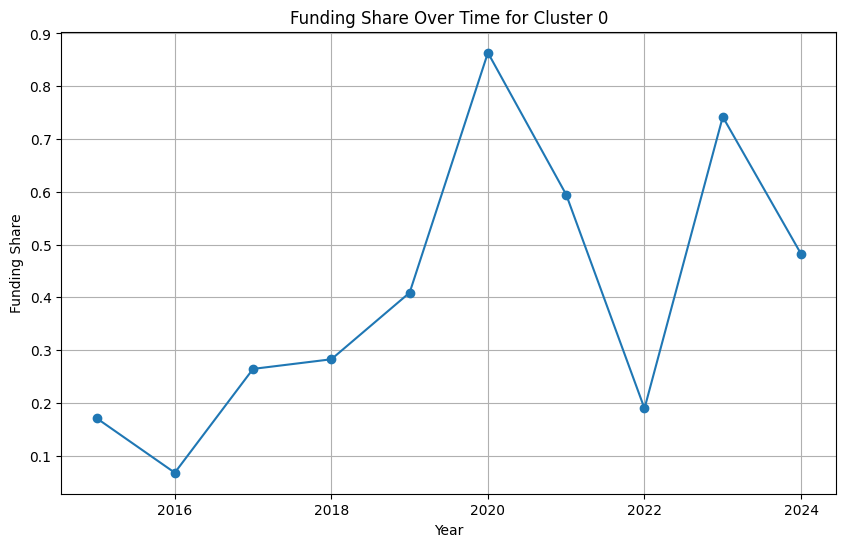

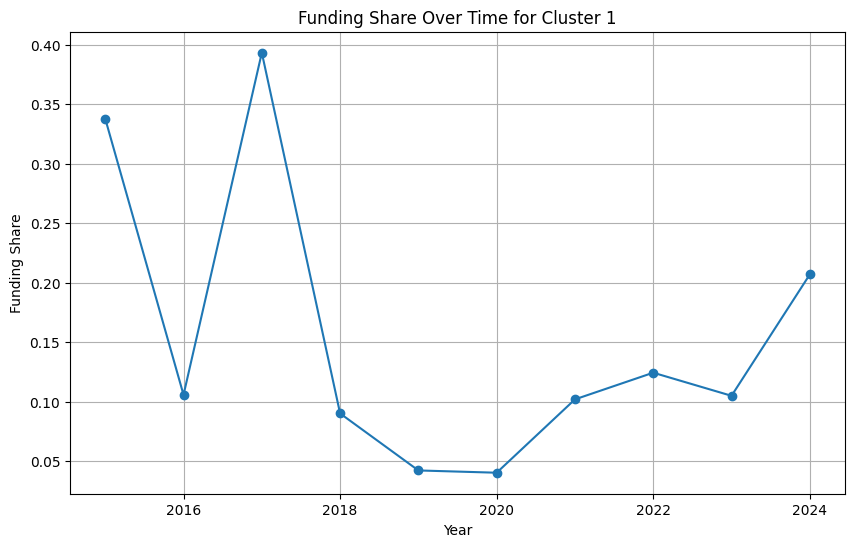

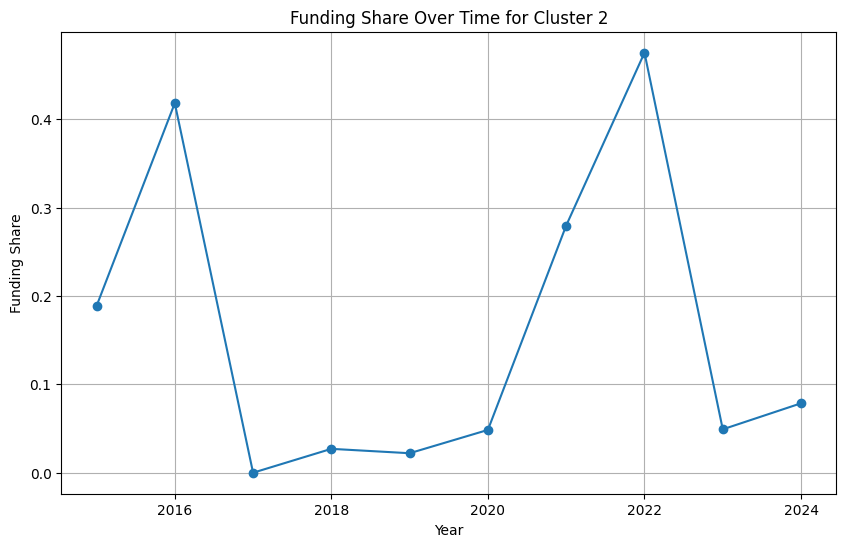

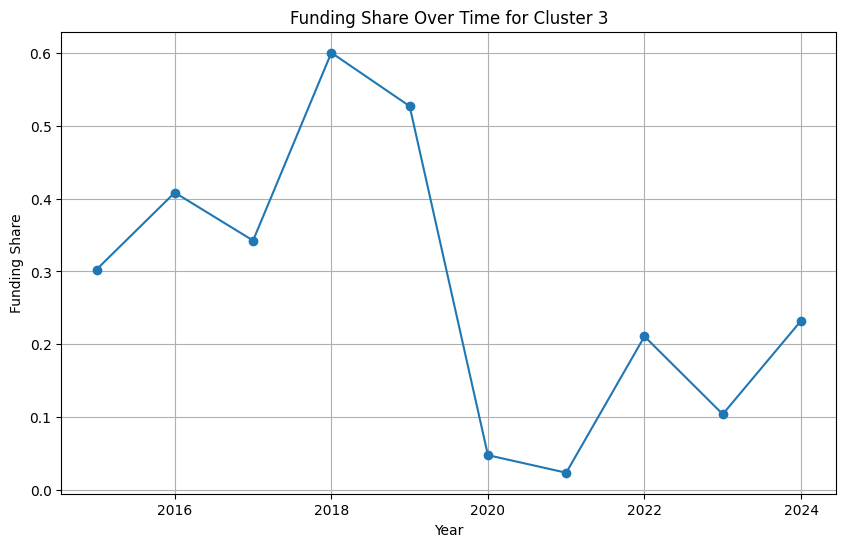

In [138]:
# 시각화
for cluster in clusters.keys():
    df_cluster = cluster_funding_by_year[cluster_funding_by_year['Cluster_keyword'] == cluster]
    plt.figure(figsize=(10, 6))
    plt.plot(df_cluster['Year'], df_cluster['Funding_Share'], marker='o')
    plt.xlabel('Year')
    plt.ylabel('Funding Share')
    plt.title(f'Funding Share Over Time for Cluster {cluster}')
    plt.grid(True)
    plt.show()

### New model - FFT

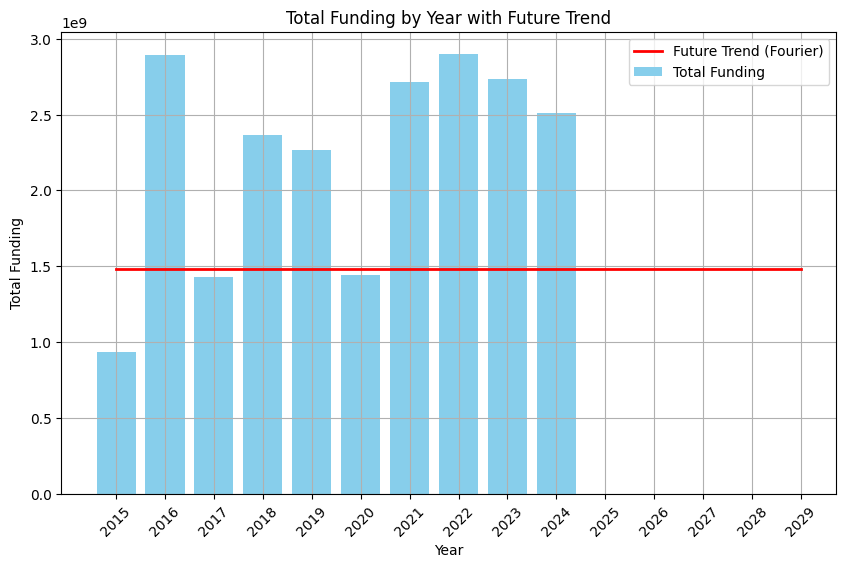

In [139]:
import re
from scipy.fft import fft, ifft


# 연도별 전체 예산 합계 계산
total_funding_by_year = df.groupby('Year')['Funding'].sum().reset_index()
total_funding_by_year.columns = ['Year', 'Total_Funding']

# Fourier 변환
years = total_funding_by_year['Year'].values
funding = total_funding_by_year['Total_Funding'].values
funding_fft = fft(funding)
funding_freq = np.fft.fftfreq(len(funding))

# 주요 주파수 성분 선택
threshold = 0.1
indices = np.where(np.abs(funding_freq) < threshold)
filtered_funding_fft = np.zeros_like(funding_fft)
filtered_funding_fft[indices] = funding_fft[indices]

# 역 Fourier 변환
filtered_funding = ifft(filtered_funding_fft).real

# 미래 예측 (향후 5년)
future_years = np.arange(years.max() + 1, years.max() + 6)
all_years = np.concatenate([years, future_years])
future_funding_fft = fft(filtered_funding)
future_funding_fft = np.concatenate([future_funding_fft, np.zeros(len(future_years))])
future_funding = ifft(future_funding_fft).real

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.bar(years, funding, color='skyblue', label='Total Funding')
plt.plot(all_years, future_funding[:len(all_years)], color='red', linewidth=2, label='Future Trend (Fourier)')
plt.xlabel('Year')
plt.ylabel('Total Funding')
plt.title('Total Funding by Year with Future Trend')
plt.xticks(all_years, rotation=45)
plt.grid(True)
plt.legend()
plt.show()

### New model

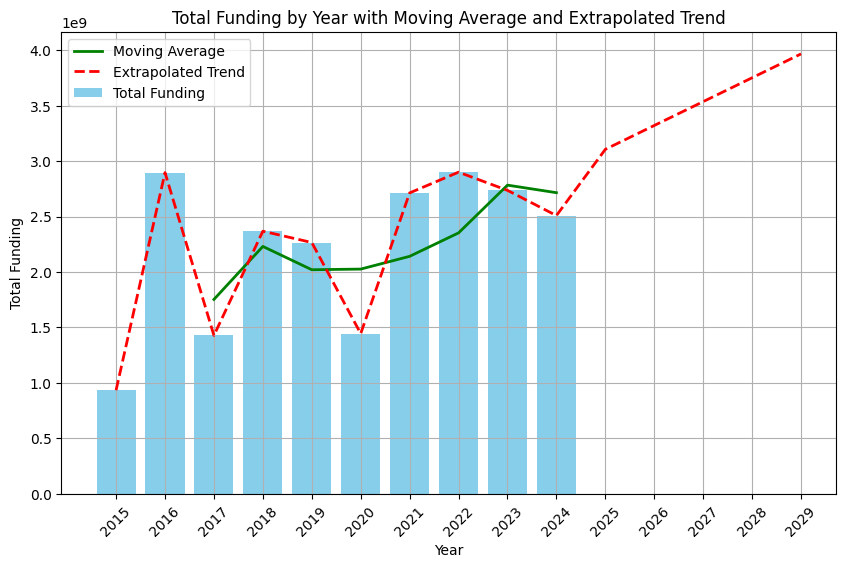

Future Funding Predictions:
   Year  Total_Funding  Moving_Average
0  2025   3.105537e+09             NaN
1  2026   3.320587e+09             NaN
2  2027   3.535637e+09             NaN
3  2028   3.750687e+09             NaN
4  2029   3.965737e+09             NaN


In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 예제 데이터프레임 생성 (실제 데이터프레임으로 대체하세요)
# df = pd.DataFrame({
#     'Year': np.arange(2000, 2024),
#     'Funding': np.random.randint(100, 500, size=24)
# })

# 연도별 전체 예산 합계 계산
total_funding_by_year = df.groupby('Year')['Funding'].sum().reset_index()
total_funding_by_year.columns = ['Year', 'Total_Funding']

# 이동 평균 계산
window_size = 3
total_funding_by_year['Moving_Average'] = total_funding_by_year['Total_Funding'].rolling(window=window_size).mean()

# 최근 몇 년간의 데이터를 사용하여 직선 외삽법 적용
recent_years = 5
recent_data = total_funding_by_year[-recent_years:]

X_recent = recent_data['Year'].values.reshape(-1, 1)
y_recent = recent_data['Total_Funding'].values

linear_model = LinearRegression()
linear_model.fit(X_recent, y_recent)

future_years = np.arange(total_funding_by_year['Year'].max() + 1, total_funding_by_year['Year'].max() + 6).reshape(-1, 1)
future_funding = linear_model.predict(future_years)

# 미래 데이터를 데이터프레임에 추가
future_df = pd.DataFrame({
    'Year': future_years.flatten(),
    'Total_Funding': future_funding,
    'Moving_Average': [np.nan] * len(future_years)
})

# 기존 데이터프레임과 결합
combined_df = pd.concat([total_funding_by_year, future_df], ignore_index=True)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(total_funding_by_year['Year'], total_funding_by_year['Total_Funding'], color='skyblue', label='Total Funding')
plt.plot(total_funding_by_year['Year'], total_funding_by_year['Moving_Average'], color='green', linewidth=2, label='Moving Average')
plt.plot(combined_df['Year'], combined_df['Total_Funding'], color='red', linestyle='dashed', linewidth=2, label='Extrapolated Trend')
plt.xlabel('Year')
plt.ylabel('Total Funding')
plt.title('Total Funding by Year with Moving Average and Extrapolated Trend')
plt.xticks(combined_df['Year'], rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 미래 데이터 출력
print("Future Funding Predictions:")
print(future_df)


예측값 파일에 저장하기

In [142]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 업로드된 CSV 파일 경로
file_path = '/Users/roycecho/Desktop/3-1/AI/data/gist_cluster_data/광학.csv'

# CSV 파일 읽기
df = pd.read_csv(file_path)

# 연도별 전체 예산 합계 계산
total_funding_by_year = df.groupby('Year')['Funding'].sum().reset_index()
total_funding_by_year.columns = ['Year', 'Total_Funding']

# 이동 평균 계산
window_size = 3
total_funding_by_year['Moving_Average'] = total_funding_by_year['Total_Funding'].rolling(window=window_size).mean()

# 최근 몇 년간의 데이터를 사용하여 직선 외삽법 적용
recent_years = 5
recent_data = total_funding_by_year[-recent_years:]

X_recent = recent_data['Year'].values.reshape(-1, 1)
y_recent = recent_data['Total_Funding'].values

linear_model = LinearRegression()
linear_model.fit(X_recent, y_recent)

future_years = np.arange(total_funding_by_year['Year'].max() + 1, total_funding_by_year['Year'].max() + 6).reshape(-1, 1)
future_funding = linear_model.predict(future_years)

# 미래 데이터를 데이터프레임에 추가
future_df = pd.DataFrame({
    'Cluster_keyword': ['광학'] * len(future_years),
    'Year': future_years.flatten(),
    'Funding': future_funding
})

# 기존 데이터프레임과 결합
combined_df = pd.concat([df, future_df], ignore_index=True)

# 결과를 CSV 파일로 저장
output_path = '/Users/roycecho/Desktop/3-1/AI/data/gist_cluster_prediction2/gist_predicted_data/gist광학_prediction.csv'
combined_df.to_csv(output_path, index=False)

output_path


'/Users/roycecho/Desktop/3-1/AI/data/gist_cluster_prediction2/gist_predicted_data/gist광학_prediction.csv'

In [68]:
# 클러스터별 연도별 예산 합계 계산
cluster_funding_by_year = df.groupby(['Cluster_keyword', 'Year'])['Funding'].sum().reset_index()

# 각 클러스터의 연도별 예산 비중 계산
cluster_funding_by_year = cluster_funding_by_year.merge(total_funding_by_year, on='Year')
cluster_funding_by_year['Funding_Share'] = cluster_funding_by_year['Funding'] / cluster_funding_by_year['Total_Funding']

# 결과 출력
print(cluster_funding_by_year)

    Cluster_keyword  Year     Funding  Total_Funding  Moving_Average  \
0                 0  2015   160099000      934721037             NaN   
1                 0  2016   196396710     2895727332             NaN   
2                 0  2017   377726906     1427947991    1.752799e+09   
3                 0  2018   669467440     2367748151    2.230474e+09   
4                 0  2019   926614962     2265831101    2.020509e+09   
5                 0  2020  1247681256     1444875696    2.026152e+09   
6                 0  2021  1613180165     2712776755    2.141161e+09   
7                 0  2022   549747268     2899862078    2.352505e+09   
8                 0  2023  2029970817     2735804063    2.782814e+09   
9                 0  2024  1209993412     2508612878    2.714760e+09   
10                1  2015   315618502      934721037             NaN   
11                1  2016   306107804     2895727332             NaN   
12                1  2017   561389335     1427947991    1.752799

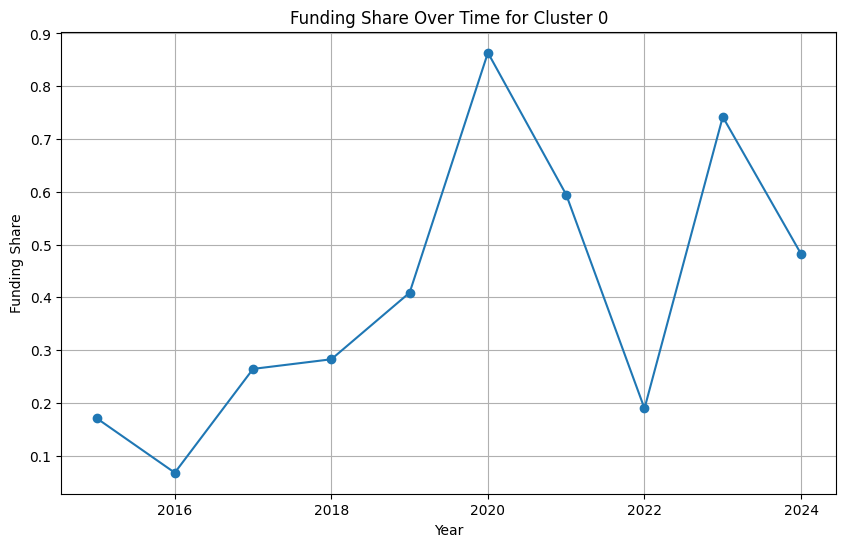

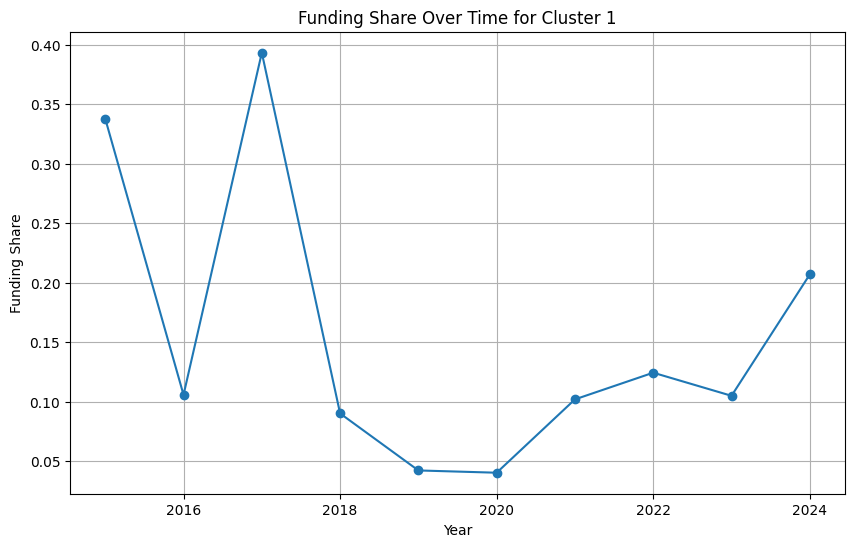

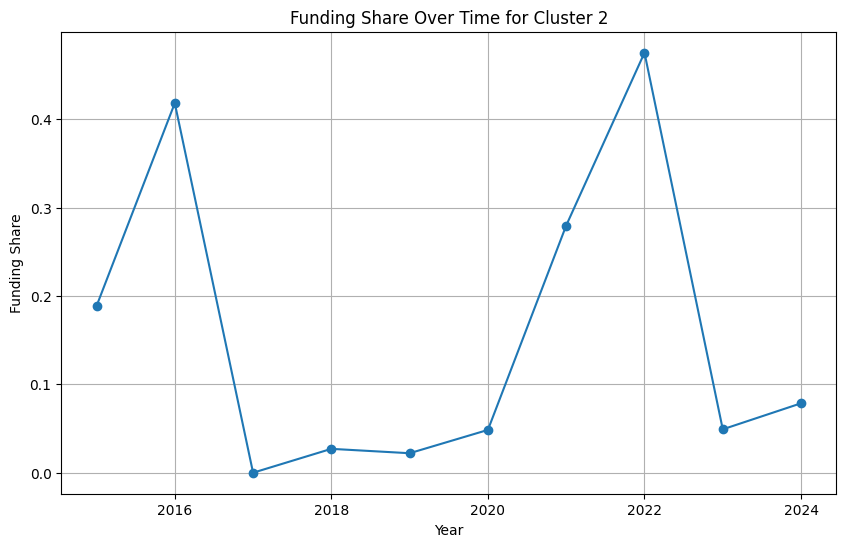

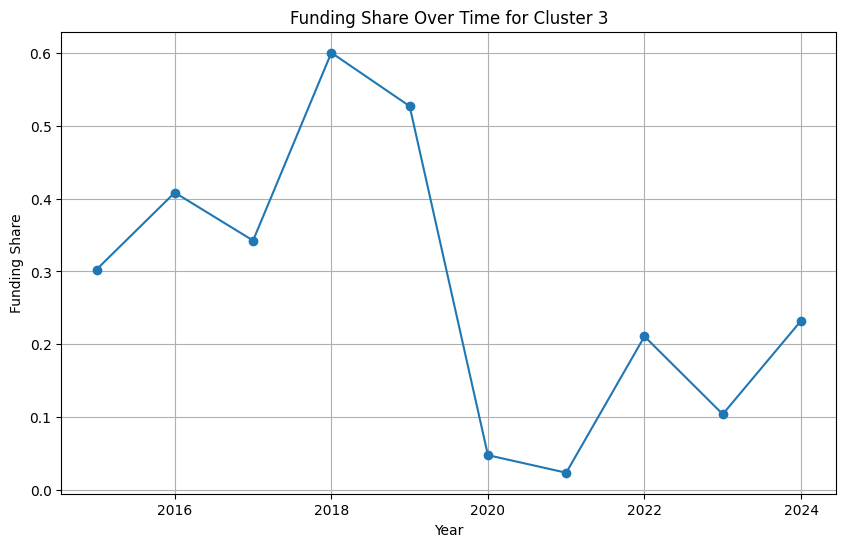

In [69]:
# 시각화
for cluster in clusters.keys():
    df_cluster = cluster_funding_by_year[cluster_funding_by_year['Cluster_keyword'] == cluster]
    plt.figure(figsize=(10, 6))
    plt.plot(df_cluster['Year'], df_cluster['Funding_Share'], marker='o')
    plt.xlabel('Year')
    plt.ylabel('Funding Share')
    plt.title(f'Funding Share Over Time for Cluster {cluster}')
    plt.grid(True)
    plt.show()



In [125]:
print(cluster_funding_by_year)

funding_share_table = cluster_funding_by_year.pivot(index='Year', columns='Cluster_keyword', values='Funding_Share')
print('-------------------------------------\n')
print(funding_share_table)

# Create the pivot table using the 'Funding' column instead of 'Funding_Share'

# Save the pivot table to a CSV file
funding_table_file_path = '/Users/roycecho/Desktop/3-1/AI/data/gist_cluster_prediction2/funding_share.csv'
funding_share_table.to_csv(funding_table_file_path)

funding_share_table.head()


    Cluster_keyword  Year     Funding  Total_Funding  Moving_Average  \
0                 0  2015   160099000      934721037             NaN   
1                 0  2016   196396710     2895727332             NaN   
2                 0  2017   377726906     1427947991    1.752799e+09   
3                 0  2018   669467440     2367748151    2.230474e+09   
4                 0  2019   926614962     2265831101    2.020509e+09   
5                 0  2020  1247681256     1444875696    2.026152e+09   
6                 0  2021  1613180165     2712776755    2.141161e+09   
7                 0  2022   549747268     2899862078    2.352505e+09   
8                 0  2023  2029970817     2735804063    2.782814e+09   
9                 0  2024  1209993412     2508612878    2.714760e+09   
10                1  2015   315618502      934721037             NaN   
11                1  2016   306107804     2895727332             NaN   
12                1  2017   561389335     1427947991    1.752799

Cluster_keyword,0,1,2,3
Year,,,,
2015,0.171280,0.337661,0.188534,0.302525
2016,0.067823,0.105710,0.418282,0.408184
2017,0.264524,0.393144,0.000000,0.342332
2018,0.282744,0.090069,0.027030,0.600157
2019,0.408951,0.042180,0.022067,0.526802


In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fourier 변환 및 예측 함수
def fourier_predict(data, n_predict):
    n = len(data)
    f = np.fft.fft(data)
    f[2:] = 0  # 주기적 성분을 유지하고 나머지는 제거
    future = np.fft.ifft(f, n + n_predict).real
    return future

# 클러스터별 Funding 비중 예측 함수
def predict_future_funding_shares(funding_share_table, clusters, n_predict, future_df):
    future_years = np.arange(funding_share_table.index.max() + 1, funding_share_table.index.max() + n_predict + 1)
    
    # 각 클러스터별로 예측된 future_funding_share 저장
    future_funding_shares = {}
    
    for cluster in clusters:
        funding_share = funding_share_table[cluster].dropna().values
        future_funding_share = fourier_predict(funding_share, n_predict)
        future_funding_shares[cluster] = future_funding_share[-n_predict:]
    
    # 예측된 비율의 총합이 1이 되도록 조정
    future_funding_shares_df = pd.DataFrame(future_funding_shares, index=future_years)
    future_funding_shares_df = future_funding_shares_df.div(future_funding_shares_df.sum(axis=1), axis=0)
    
    # Total Funding과 예측된 비율을 곱하여 Predicted Funding 계산
    total_funding = future_df['Total_Funding'].values
    predicted_funding = future_funding_shares_df.multiply(total_funding, axis=0)
    
    return future_funding_shares_df, predicted_funding
'''
# 예시 데이터
data = {
    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    '0': [0.171280, 0.067823, 0.264524, 0.282744, 0.408951, 0.863522, 0.594660, 0.189577, 0.742002, 0.482336],
    '1': [0.337661, 0.105710, 0.393144, 0.090069, 0.042180, 0.040266, 0.101899, 0.124301, 0.104893, 0.206845],
    '2': [0.188534, 0.418282, 0.000000, 0.027030, 0.022067, 0.048447, 0.279786, 0.475338, 0.049119, 0.078573],
    '3': [0.302525, 0.408184, 0.342332, 0.600157, 0.526802, 0.047765, 0.023654, 0.210784, 0.103987, 0.232247]
}

funding_share_table = pd.DataFrame(data).set_index('Year')

# 미래 Total Funding 데이터프레임
future_df = pd.DataFrame({
    'Year': [2025, 2026, 2027, 2028, 2029],
    'Total_Funding': [3.105537e+09, 3.320587e+09, 3.535637e+09, 3.750687e+09, 3.965737e+09],
    'Moving_Average': [None, None, None, None, None]
})
'''


"\n# 예시 데이터\ndata = {\n    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],\n    '0': [0.171280, 0.067823, 0.264524, 0.282744, 0.408951, 0.863522, 0.594660, 0.189577, 0.742002, 0.482336],\n    '1': [0.337661, 0.105710, 0.393144, 0.090069, 0.042180, 0.040266, 0.101899, 0.124301, 0.104893, 0.206845],\n    '2': [0.188534, 0.418282, 0.000000, 0.027030, 0.022067, 0.048447, 0.279786, 0.475338, 0.049119, 0.078573],\n    '3': [0.302525, 0.408184, 0.342332, 0.600157, 0.526802, 0.047765, 0.023654, 0.210784, 0.103987, 0.232247]\n}\n\nfunding_share_table = pd.DataFrame(data).set_index('Year')\n\n# 미래 Total Funding 데이터프레임\nfuture_df = pd.DataFrame({\n    'Year': [2025, 2026, 2027, 2028, 2029],\n    'Total_Funding': [3.105537e+09, 3.320587e+09, 3.535637e+09, 3.750687e+09, 3.965737e+09],\n    'Moving_Average': [None, None, None, None, None]\n})\n"

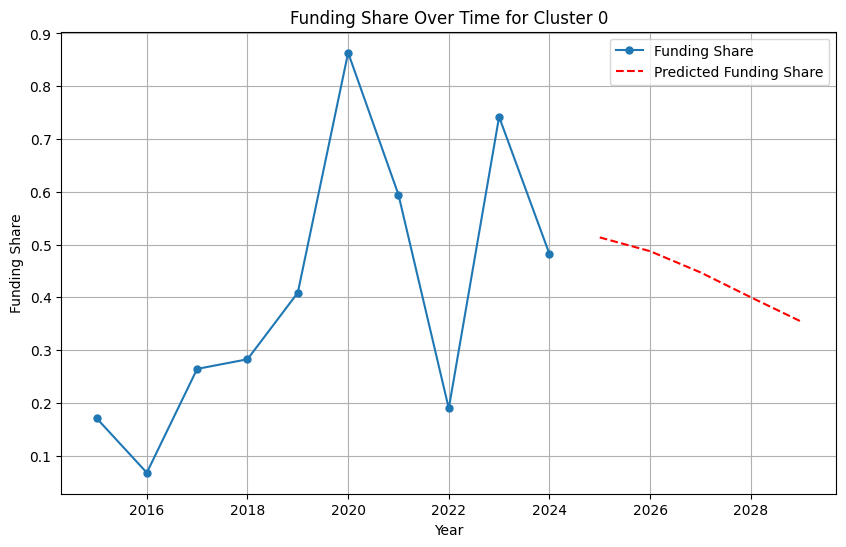

Future Funding Share and Funding for Cluster 0:
       Year  Predicted_Funding_Share  Predicted_Funding
2025  2025                 0.513649       1.595157e+09
2026  2026                 0.487524       1.618865e+09
2027  2027                 0.447430       1.581950e+09
2028  2028                 0.400301       1.501404e+09
2029  2029                 0.354286       1.405004e+09


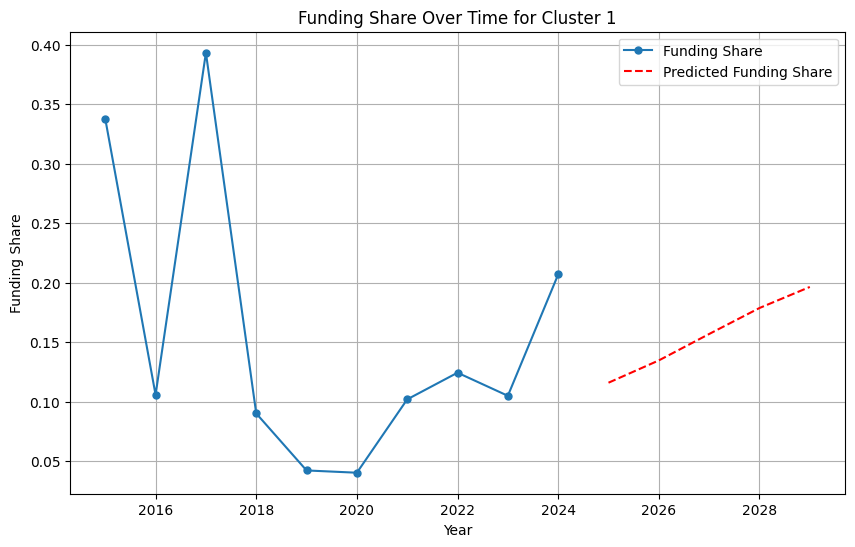

Future Funding Share and Funding for Cluster 1:
       Year  Predicted_Funding_Share  Predicted_Funding
2025  2025                 0.115895       3.599169e+08
2026  2026                 0.134624       4.470301e+08
2027  2027                 0.156823       5.544700e+08
2028  2028                 0.178655       6.700789e+08
2029  2029                 0.196344       7.786491e+08


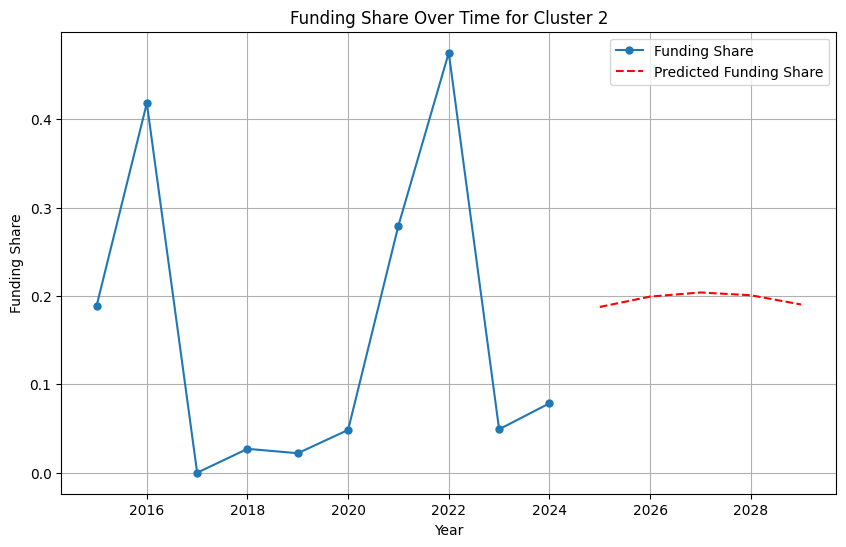

Future Funding Share and Funding for Cluster 2:
       Year  Predicted_Funding_Share  Predicted_Funding
2025  2025                 0.187625       5.826756e+08
2026  2026                 0.199324       6.618739e+08
2027  2027                 0.204003       7.212795e+08
2028  2028                 0.200851       7.533286e+08
2029  2029                 0.190414       7.551309e+08


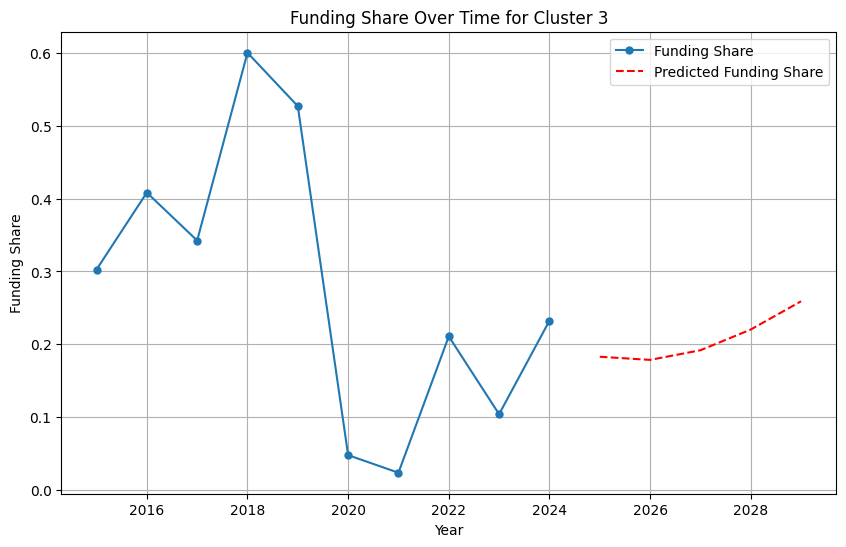

Future Funding Share and Funding for Cluster 3:
       Year  Predicted_Funding_Share  Predicted_Funding
2025  2025                 0.182831       5.677872e+08
2026  2026                 0.178528       5.928183e+08
2027  2027                 0.191744       6.779375e+08
2028  2028                 0.220193       8.258760e+08
2029  2029                 0.258957       1.026953e+09


In [117]:
# 모든 클러스터의 예측 수행 및 결과 출력

n_predict = 5  # 향후 5년 예측

future_funding_shares_df, predicted_funding_df = predict_future_funding_shares(funding_share_table, clusters, n_predict, future_df)


# 예측 결과 출력
for cluster in clusters:
    plt.figure(figsize=(10, 6))
    plt.plot(funding_share_table.index, funding_share_table[cluster], 'o-', label='Funding Share', markersize=5)
    plt.plot(future_funding_shares_df.index, future_funding_shares_df[cluster], 'r--', label='Predicted Funding Share')
    plt.xlabel('Year')
    plt.ylabel('Funding Share')
    plt.title(f'Funding Share Over Time for Cluster {cluster}')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    future_funding_share = pd.DataFrame({
        'Year': future_funding_shares_df.index,
        'Predicted_Funding_Share': future_funding_shares_df[cluster],
        'Predicted_Funding': predicted_funding_df[cluster]
    })
    print(f"Future Funding Share and Funding for Cluster {cluster}:\n", future_funding_share)

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fourier 변환 및 예측 함수
def fourier_predict(data, n_predict):
    n = len(data)
    f = np.fft.fft(data)
    f[2:] = 0  # 주기적 성분을 유지하고 나머지는 제거
    future = np.fft.ifft(f, n + n_predict).real
    return future

# 클러스터별 Funding 비중 예측 함수
def predict_future_funding_share(funding_share_table, cluster, n_predict, future_df):
    funding_share = funding_share_table[cluster].dropna().values
    future_funding_share = fourier_predict(funding_share, n_predict)
    future_years = np.arange(funding_share_table.index.max() + 1, funding_share_table.index.max() + n_predict + 1)
    total_funding = future_df['Total_Funding'].values
    # 예측된 비율의 총합이 1이 되도록 조정
    future_funding_share_total = future_funding_share[-n_predict:].sum()
    future_funding_share[-n_predict:] /= future_funding_share[-n_predict:].sum()

    total_funding_future = np.full(n_predict, funding_share_table.iloc[-1].sum())
    predicted_funding = future_funding_share[-n_predict:] * total_funding

    plt.figure(figsize=(10, 6))
    plt.plot(funding_share_table.index, funding_share_table[cluster], 'o-', label='Funding Share', markersize=5)
    plt.plot(future_years, future_funding_share[-n_predict:], 'r--', label='Predicted Funding Share')
    plt.xlabel('Year')
    plt.ylabel('Funding Share')
    plt.title(f'Funding Share Over Time for Cluster {cluster}')
    plt.grid(True)
    plt.legend()
    plt.show()
    #return pd.DataFrame({'Year' : future_years,  'Predicted_Funding': predicted_funding})
    return pd.DataFrame({'Year': future_years, 'Predicted_Funding_Share': future_funding_share[-n_predict:], 'Predicted_Funding': predicted_funding})


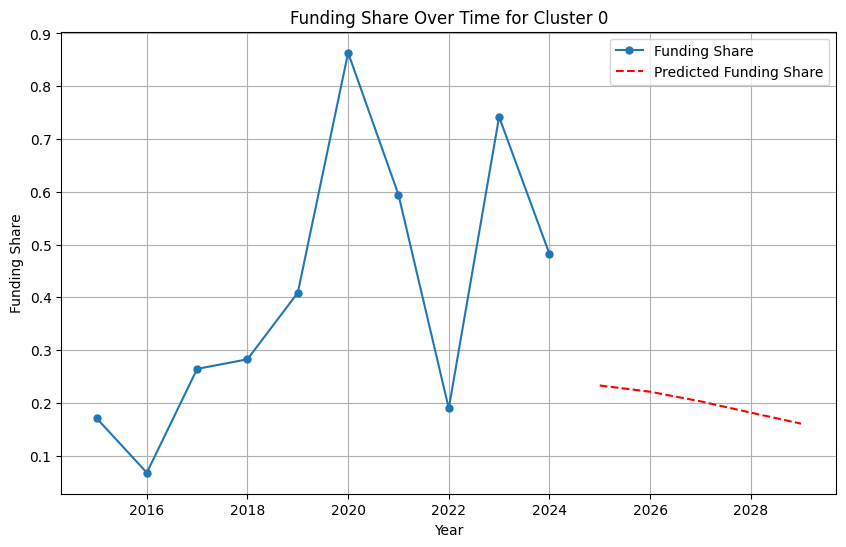

Future Funding Share and Funding for Cluster 0:
    Year  Predicted_Funding_Share  Predicted_Funding
0  2025                 0.233139       7.240218e+08
1  2026                 0.221281       7.347823e+08
2  2027                 0.203083       7.180271e+08
3  2028                 0.181692       6.814682e+08
4  2029                 0.160806       6.377135e+08


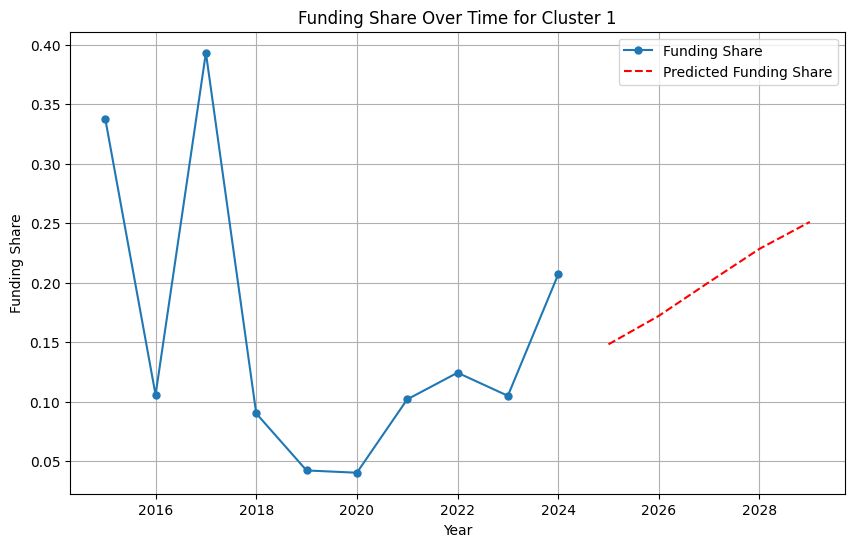

Future Funding Share and Funding for Cluster 1:
    Year  Predicted_Funding_Share  Predicted_Funding
0  2025                 0.148139       4.600511e+08
1  2026                 0.172078       5.714005e+08
2  2027                 0.200454       7.087316e+08
3  2028                 0.228359       8.565044e+08
4  2029                 0.250970       9.952803e+08


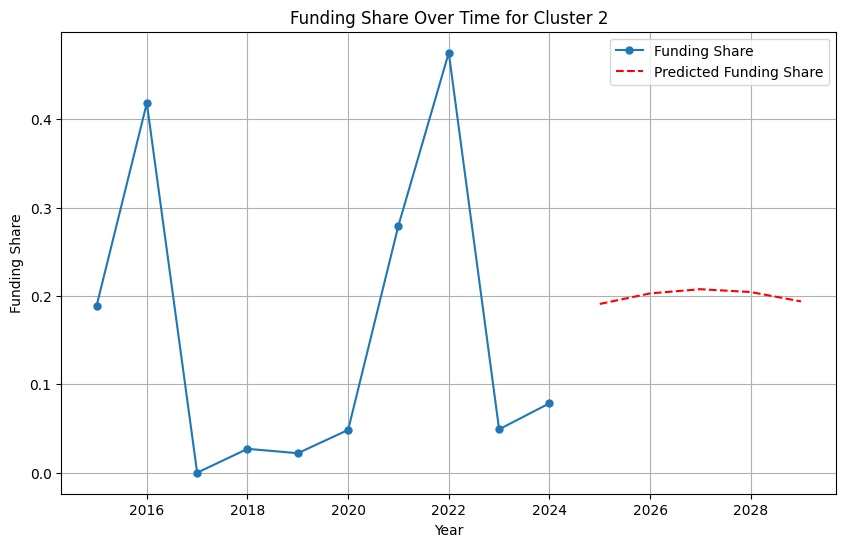

Future Funding Share and Funding for Cluster 2:
    Year  Predicted_Funding_Share  Predicted_Funding
0  2025                 0.191022       5.932252e+08
1  2026                 0.202933       6.738575e+08
2  2027                 0.207696       7.343387e+08
3  2028                 0.204487       7.669682e+08
4  2029                 0.193861       7.688031e+08


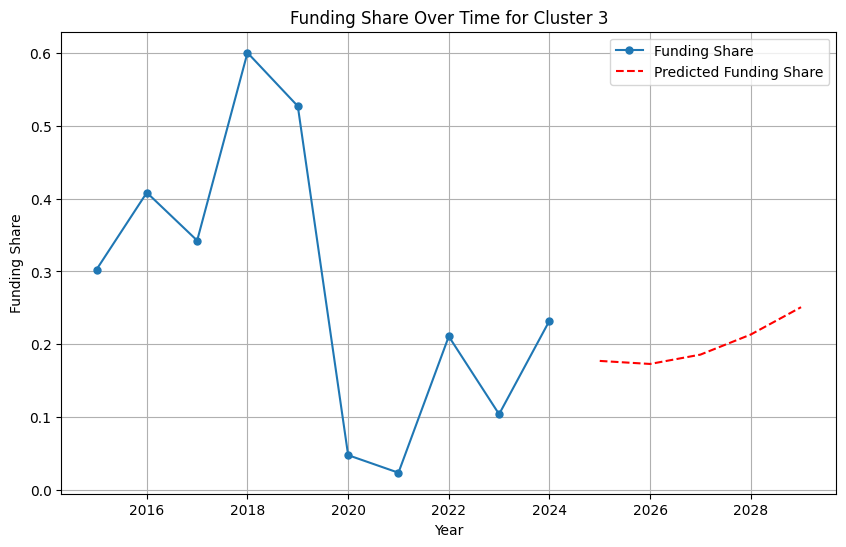

Future Funding Share and Funding for Cluster 3:
    Year  Predicted_Funding_Share  Predicted_Funding
0  2025                 0.177118       5.500466e+08
1  2026                 0.172950       5.742957e+08
2  2027                 0.185753       6.567555e+08
3  2028                 0.213313       8.000717e+08
4  2029                 0.250865       9.948666e+08


In [96]:
# 클러스터별 예측 및 시각화
n_predict = 5  # 향후 5년 예측
for cluster in clusters.keys():
    future_funding_share = predict_future_funding_share(funding_share_table, cluster, n_predict, future_df)
    print(f"Future Funding Share and Funding for Cluster {cluster}:\n", future_funding_share)

In [87]:

# Fourier 변환 및 예측 함수
def fourier_predict(data, n_predict):
    n = len(data)
    f = np.fft.fft(data)
    f[2:] = 0  # 주기적 성분을 유지하고 나머지는 제거
    future = np.fft.ifft(f, n + n_predict).real
    return future

# 클러스터별 Funding 비중 예측 함수
def predict_future_funding_share(funding_share_table, cluster, n_predict):
    funding_share = funding_share_table[cluster].dropna().values
    future_funding_share = fourier_predict(funding_share, n_predict)
    future_years = np.arange(funding_share_table.index.max() + 1, funding_share_table.index.max() + n_predict + 1)

    total_funding_future = np.full(n_predict, df_cluster['Total_Funding'].iloc[-1])
    predicted_funding = future_funding_share[-n_predict:] * total_funding_future

    plt.figure(figsize=(10, 6))
    plt.plot(funding_share_table.index, funding_share_table[cluster], 'o-', label='Funding Share', markersize=5)
    plt.plot(future_years, future_funding_share[-n_predict:], 'r--', label='Predicted Funding Share')
    plt.xlabel('Year')
    plt.ylabel('Funding Share')
    plt.title(f'Funding Share Over Time for Cluster {cluster}')
    plt.grid(True)
    plt.legend()
    plt.show()

    return pd.DataFrame({'Year': future_years, 'Predicted_Funding_Share': future_funding_share[-n_predict:], 'Predicted_Funding': predicted_funding, 'Total' : total_funding_future})


In [124]:
import os

output_dir = '/Users/roycecho/Desktop/3-1/AI/data/ntis'
os.makedirs(output_dir, exist_ok=True)

for cluster in clusters:
    future_funding_share = pd.DataFrame({
        'Year': future_funding_shares_df.index,
        'Predicted_Funding_Share': future_funding_shares_df[cluster],
        'Predicted_Funding': predicted_funding_df[cluster]
    })
    cluster_file_path = os.path.join(output_dir, f'Cluster_{cluster}.csv')
    future_funding_share.to_csv(cluster_file_path, index=False)


'/Users/roycecho/Desktop/3-1/AI/data/gist_cluster_prediction_2/0/predicted_0.csv'

In [123]:

# Fourier 변환 및 예측 함수
def fourier_predict(data, n_predict):
    n = len(data)
    f = np.fft.fft(data)
    f[2:] = 0  # 주기적 성분을 유지하고 나머지는 제거
    future = np.fft.ifft(f, n + n_predict).real
    return future

# 클러스터별 Funding 비중 예측 함수
def predict_future_funding_share(funding_share_table, cluster, n_predict):
    funding_share = funding_share_table[cluster].dropna().values
    future_funding_share = fourier_predict(funding_share, n_predict)
    future_years = np.arange(funding_share_table.index.max() + 1, funding_share_table.index.max() + n_predict + 1)

    return future_years, future_funding_share[-n_predict:]

# 클러스터별 예측 및 시각화
n_predict = 5  # 향후 5년 예측
plt.figure(figsize=(12, 8))

for cluster in clusters.keys():
    future_years, future_funding_share = predict_future_funding_share(funding_share_table, cluster, n_predict)
    plt.plot(funding_share_table.index, funding_share_table[cluster], 'o-', label=f'Cluster {cluster} Funding Share', markersize=5)
    plt.plot(future_years, future_funding_share, '--', label=f'Cluster {cluster} Predicted', linestyle='dashed')

plt.xlabel('Year')
plt.ylabel('Funding Share')
plt.title('Funding Share Over Time for All Clusters')
plt.grid(True)
plt.legend()
plt.show()

# 개별 클러스터별 예측 데이터프레임 출력
for cluster in clusters:
    future_years, future_funding_share = predict_future_funding_share(funding_share_table, cluster, n_predict)
    future_df = pd.DataFrame({'Year': future_years, 'Predicted_Funding_Share': future_funding_share})
    print(f"Future Funding Share for Cluster {cluster}:\n", future_df)

AttributeError: 'list' object has no attribute 'keys'

<Figure size 1200x800 with 0 Axes>

### RSME clustering

In [ ]:
# 클러스터링 및 RMSE 계산 함수
def cluster_and_calculate_rmse(X, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(X)

    total_rmse = 0
    for cluster in range(num_clusters):
        cluster_indices = np.where(clusters == cluster)[0]
        cluster_data = X[cluster_indices]

        # RMSE 계산
        for i in range(len(cluster_data)):
            for j in range(i+1, len(cluster_data)):
                rmse = np.sqrt(mean_squared_error(cluster_data[i], cluster_data[j]))
                total_rmse += rmse

    average_rmse = total_rmse / (len(X) * (len(X) - 1) / 2)  # 평균 RMSE
    return clusters, average_rmse

In [11]:
'''
# 최적의 클러스터링 찾기
best_clusters = None
best_rmse = float('inf')

for _ in range(10):  # 10번 반복하여 최적의 클러스터링을 찾음 # Hyperparameter
    clusters, rmse = cluster_and_calculate_rmse(X, 4)
    if rmse < best_rmse:
        best_rmse = rmse
        best_clusters = clusters

# 결과 출력
keyword_to_cluster = {keyword: cluster for keyword, cluster in zip(pivot_df.columns, best_clusters)}

# 각 클러스터별 키워드 출력
cluster_groups = {}
for cluster in range(4):
    cluster_groups[cluster] = [keyword for keyword, cl in keyword_to_cluster.items() if cl == cluster]

# 결과 출력
for cluster, keywords in cluster_groups.items():
    print(f"Cluster {cluster}: {keywords}")

print(f"Best RMSE: {best_rmse}")

# 결과 딕셔너리
print(cluster_groups)
'''

'\n# 최적의 클러스터링 찾기\nbest_clusters = None\nbest_rmse = float(\'inf\')\n\nfor _ in range(10):  # 10번 반복하여 최적의 클러스터링을 찾음 # Hyperparameter\n    clusters, rmse = cluster_and_calculate_rmse(X, 4)\n    if rmse < best_rmse:\n        best_rmse = rmse\n        best_clusters = clusters\n\n# 결과 출력\nkeyword_to_cluster = {keyword: cluster for keyword, cluster in zip(pivot_df.columns, best_clusters)}\n\n# 각 클러스터별 키워드 출력\ncluster_groups = {}\nfor cluster in range(4):\n    cluster_groups[cluster] = [keyword for keyword, cl in keyword_to_cluster.items() if cl == cluster]\n\n# 결과 출력\nfor cluster, keywords in cluster_groups.items():\n    print(f"Cluster {cluster}: {keywords}")\n\nprint(f"Best RMSE: {best_rmse}")\n\n# 결과 딕셔너리\nprint(cluster_groups)\n'

## Finding Best Polynomial Regression


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


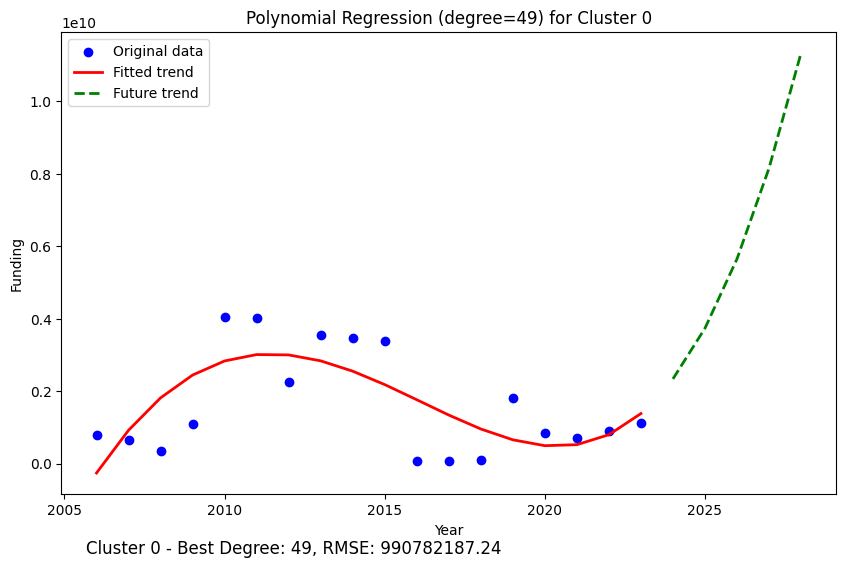

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


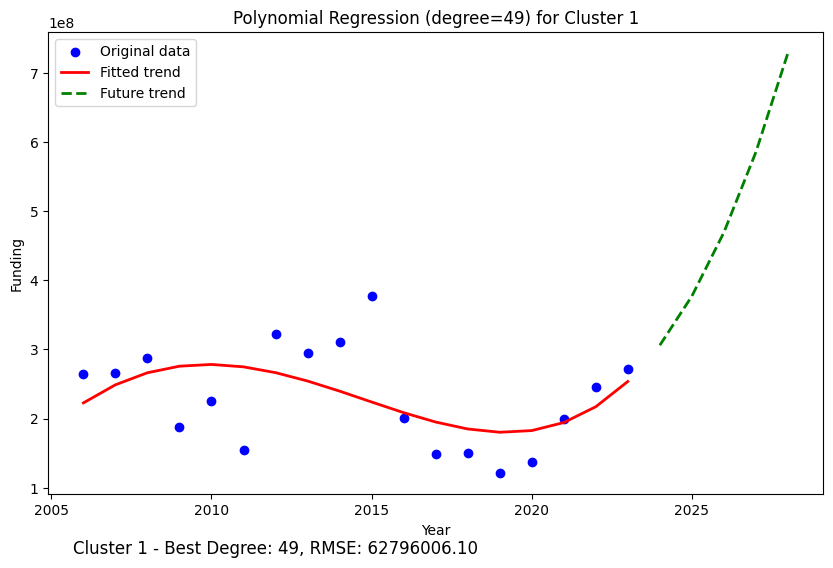

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


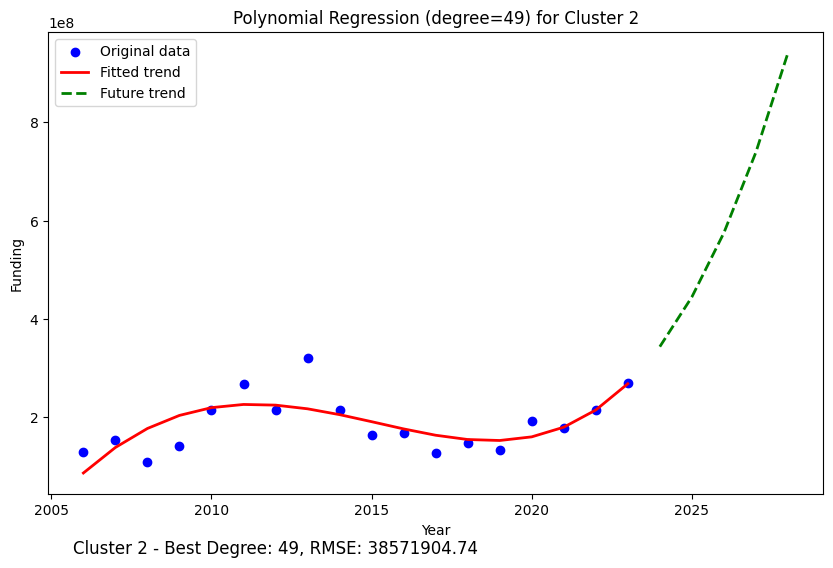

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


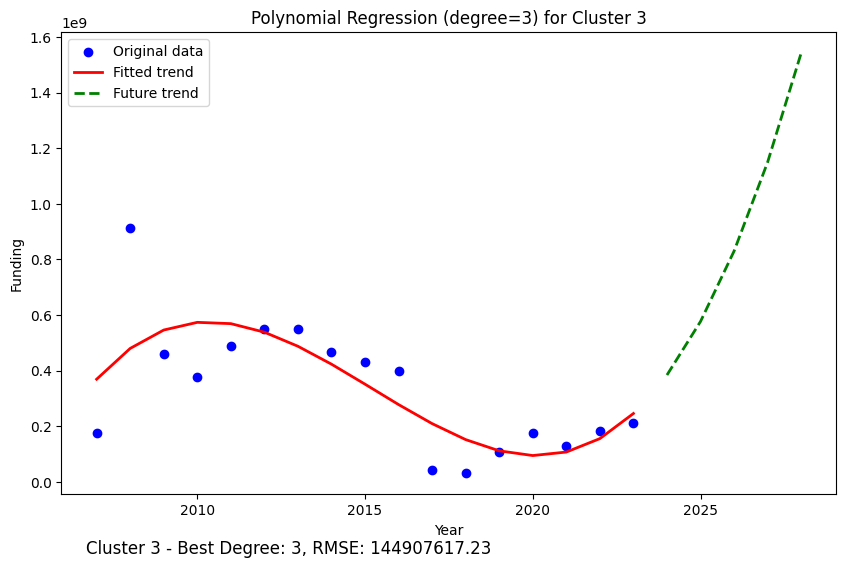

Cluster 0 - Best Degree: 49, RMSE: 990782187.24
Cluster 1 - Best Degree: 49, RMSE: 62796006.10
Cluster 2 - Best Degree: 49, RMSE: 38571904.74
Cluster 3 - Best Degree: 3, RMSE: 144907617.23


In [ ]:

# 클러스터별 연도별 평균 Funding 계산
mean_funding_by_year = df.groupby(['Cluster', 'Year'])['Funding'].mean().reset_index()

# Polynomial Regression 모델 학습 및 시각화 함수
def polynomial_regression_and_plot(df_cluster, cluster, degree=3):
    X = df_cluster[['Year']]
    y = df_cluster['Funding']

    best_degree = 1
    best_rmse = float('inf')

    for degree in range(1, 50):
        # 다항 피처 생성
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)

        # Polynomial Regression 모델 학습
        model = LinearRegression()
        model.fit(X_poly, y)

        # 예측값 계산
        y_pred = model.predict(X_poly)

        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(y, y_pred))

        if rmse < best_rmse:
            best_rmse = rmse
            best_degree = degree

    # 최적 degree로 다시 학습 및 시각화
    poly = PolynomialFeatures(degree=best_degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)

    # 다음 5년 예측
    future_years = np.array([[year] for year in range(X['Year'].max() + 1, X['Year'].max() + 6)])
    future_years_poly = poly.transform(future_years)
    future_pred = model.predict(future_years_poly)

    # 최종 RMSE 계산
    final_rmse = np.sqrt(mean_squared_error(y, y_pred))

    # 결과 시각화
    plt.figure(figsize=(10, 6))

    # 원본 데이터 포인트
    plt.scatter(X['Year'], y, color='blue', label='Original data')

    # 예측 데이터 포인트
    plt.plot(X['Year'], y_pred, color='red', linewidth=2, label='Fitted trend')

    # 미래 예측 데이터 포인트
    plt.plot(future_years, future_pred, color='green', linestyle='dashed', linewidth=2, label='Future trend')

    plt.xlabel('Year')
    plt.ylabel('Funding')
    plt.title(f'Polynomial Regression (degree={best_degree}) for Cluster {cluster}')
    plt.legend()

    # 각 그래프 밑에 클러스터 번호, 최적의 다항식 차수, RMSE 값을 출력
    plt.figtext(0.15, 0.01, f'Cluster {cluster} - Best Degree: {best_degree}, RMSE: {final_rmse:.2f}', wrap=True, horizontalalignment='left', fontsize=12)

    plt.show()

    return best_degree, final_rmse

# 클러스터별 Polynomial Regression 적용 및 시각화
cluster_results = []

for cluster in range(num_clusters):
    df_cluster = mean_funding_by_year[mean_funding_by_year['Cluster'] == cluster]
    if not df_cluster.empty:
        best_degree, rmse = polynomial_regression_and_plot(df_cluster, cluster)
        cluster_results.append((cluster, best_degree, rmse))

# 결과 출력
for cluster, degree, rmse in cluster_results:
    print(f"Cluster {cluster} - Best Degree: {degree}, RMSE: {rmse:.2f}")